Este Jupyter notebook contém uma exposição sucinta da _codebase_ utilizada no trabalho de simulação discreta. Seu propósito primário é instruir o usuário à utilização do código contido no repositório [@ygarasab/popcorn-production](https://github.com/ygarasab/popcorn-production).

# Requisitos

In [1]:
import numpy as np
import pandas as pd
import codigo.simulacao as sim
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
from matplotlib import ticker as tkr
from datetime import datetime
from codigo.simulacao.entidades.subentidade import SubEntidade

# Pré-processando o conjunto de dados

Começamos importando nosso dataset como um `DataFrame`.

In [3]:
df = pd.read_csv('dados/Production.csv').drop(['EmergencyStop'], axis=1)

In [4]:
df_n_linhas, df_n_colunas = df.shape[0], df.shape[1]
df_colunas = df.columns

In [5]:
df.head(5)

,Timestamp,CupState,CurrentWeight,FanOn,HeatCoverClosed,HeaterOn,HeatingTimePercent,PotAvailable,Produce,ScaleCupDown,ScaleCupUp,SwitchToPot,TrackSwitchAtCup,TrackSwitchAtPot,TurnScaleCup
0,1516355920018,1,0.092367,0,1,0,0,1,0,0,1,0,1,0,0
1,1516355920120,1,0.153945,0,1,0,0,1,0,0,1,0,1,0,0
2,1516355920229,1,0.092367,0,1,0,0,1,0,0,1,0,1,0,0
3,1516355920339,1,0.123156,0,1,0,0,1,0,0,1,0,1,0,0
4,1516355920450,1,0.123156,0,1,0,0,1,0,0,1,0,1,0,0


Em seguida, convertemos as _timestamps_ para um formato mais amigável.

In [6]:
for index in range(df_n_linhas):
    unix_ts = df.at[index, 'Timestamp']
    df.at[index, 'Timestamp'] = datetime.fromtimestamp(unix_ts/1000)

In [7]:
df.head(5)

,Timestamp,CupState,CurrentWeight,FanOn,HeatCoverClosed,HeaterOn,HeatingTimePercent,PotAvailable,Produce,ScaleCupDown,ScaleCupUp,SwitchToPot,TrackSwitchAtCup,TrackSwitchAtPot,TurnScaleCup
0,2018-01-19 06:58:40.018000,1,0.092367,0,1,0,0,1,0,0,1,0,1,0,0
1,2018-01-19 06:58:40.120000,1,0.153945,0,1,0,0,1,0,0,1,0,1,0,0
2,2018-01-19 06:58:40.229000,1,0.092367,0,1,0,0,1,0,0,1,0,1,0,0
3,2018-01-19 06:58:40.339000,1,0.123156,0,1,0,0,1,0,0,1,0,1,0,0
4,2018-01-19 06:58:40.450000,1,0.123156,0,1,0,0,1,0,0,1,0,1,0,0


Uma vez feito isso, iniciamos os preparativos para a coleta dos tempos de execução de cada etapa.

In [8]:
df_aux = df.iloc[:7596]
dfaux_n_linhas = df_aux.shape[0]

In [9]:
periodos = [990, 1962, 2992, 3857, 4812, 5806, 6704, 7596]
tempos = {
    tempo: [] for tempo in [
        'Enchimento da panela',
        'Ligação do aquecedor',
        'Aquecimento da panela',
        'Enchimento do copo',
        'Despejo do copo'
    ]
}

E, ao fim, realizamos a coleta dos tempos de execução.

In [10]:
for periodo in periodos[:-1]:
    index = periodos.index(periodo)+1
    df = df_aux.iloc[periodo:periodos[index]]

    # 1 - Tempo de enchimento da panela
    tempo = df.query('CupState == 0')['Timestamp'].values
    tempo = tempo[-1] - tempo[0]
    tempos['Enchimento da panela'].append(float('{}.{}'.format(tempo.seconds, tempo.microseconds)))
    
    # 2 - Tempo entre momento que o processo iniciou e o aquecedor ligou
    tempo = df.query('HeaterOn == 0')['Timestamp'].values[0]
    tempo_aux = df.query('HeaterOn == 1')['Timestamp'].values[0]
    tempo = tempo_aux - tempo
    tempos['Ligação do aquecedor'].append(float('{}.{}'.format(tempo.seconds, tempo.microseconds)))
    
    # 3 - Tempo do momento que o aquecedor ligou, até começar a encher o copo de pipoca 
    tempo = df.query('HeaterOn == 1')['Timestamp'].values[0]
    tempo_aux = df.query('HeaterOn == 1').query('CurrentWeight > 1')['Timestamp'].values[0]
    tempo = tempo_aux - tempo
    tempos['Aquecimento da panela'].append(float('{}.{}'.format(tempo.seconds, tempo.microseconds)))
    
    # 4 - Tempo entre o momento que o copo começa a encher de pipoca até o momento que começa a despejar (CupState: 1 -> 2)
    tempo = df.query('HeaterOn == 1').query('CurrentWeight > 1')['Timestamp'].values[0]
    tempo_aux = df.query('CupState == 2')['Timestamp'].values[0]
    tempo = tempo_aux - tempo
    tempos['Enchimento do copo'].append(float('{}.{}'.format(tempo.seconds, tempo.microseconds)))
    
    # 5 - Tempo de despejo de pipoca
    tempo = df.query('CupState == 2')['Timestamp'].values[0]
    tempo_aux = df.iloc[-1]['Timestamp']
    tempo = tempo_aux - tempo
    tempos['Despejo do copo'].append(float('{}.{}'.format(tempo.seconds, tempo.microseconds)))

Assim, temos nossos tempos de execução como:

In [11]:
tempos = pd.DataFrame(tempos)
tempos

,Enchimento da panela,Ligação do aquecedor,Aquecimento da panela,Enchimento do copo,Despejo do copo
0,4.266,16.189,41.237,7.876,40.909
1,3.829,16.298,38.722,7.328,50.207
2,4.156,7.547,16.845,25.490,45.660
3,5.141,184.310,33.581,7.875,45.722
4,9.626,22.205,32.377,8.860,45.175
5,3.828,12.907,0.000,40.690,44.519
6,3.391,10.720,30.631,9.950,46.160


# Obtendo a distribuição dos tempos de cada etapa da execução

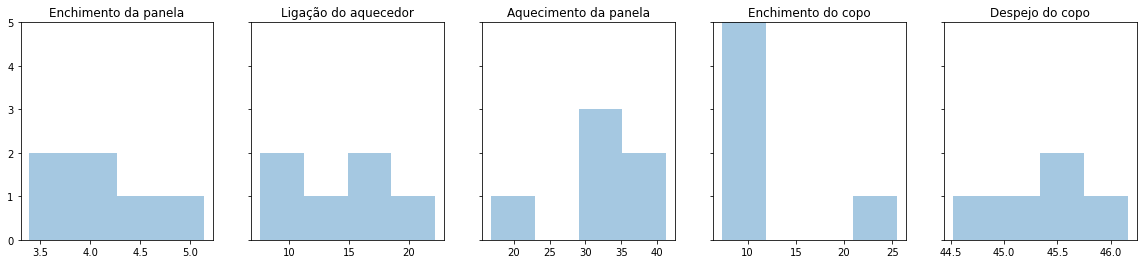

In [12]:
figura, eixos = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for indice, coluna in enumerate(tempos.columns):
    dados_filtrados = SubEntidade._filtra_outliers(tempos.loc[:, coluna])
    sns.distplot(dados_filtrados, bins=4, kde=False, ax=eixos.ravel()[indice])
    eixos.ravel()[indice].set_title(coluna)
    eixos.ravel()[indice].set_xlabel("")
    eixos.ravel()[indice].set_ylabel("")
    eixos.ravel()[indice].set_ylim(0, 5)
    eixos.ravel()[indice].yaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))
    eixos.ravel()[indice].yaxis.set_major_locator(tkr.MaxNLocator(integer=True))

# Executando a simulação

Agora, vamos começar nossas simulações de fato, com nossa implementação importada como `sim`.

Para esse experimento, vamos verificar o desempenho do sistema em quatro cenários:
    
- *Controle:* cenário original, sem alterações
- *Com a panela sempre cheia:* cenário onde não esvaziamos a panela
- *Com o aquecedor sempre ligado:* cenário onde não desligamos o aquecedor
- *Ambas otimizações:* cenário onde aplicamos ambas práticas

Para facilitar nossos testes, escrevemos a seguinte rotina:

In [13]:
def executa_processo(tempos, limite_de_tempo, execucoes):
    # Definição de váriaveis containner
    figura, eixo = plt.subplots(1, 1)
    tempos_de_producao = {}
    
    # Iteração principal para realizar a execução sobre cada cenário
    for estado_do_aquecedor in [False, True]:
        for estado_da_panela in [False, True]:
            
            if estado_do_aquecedor is False:
                categoria = "Controle" if estado_da_panela is False else "Panela sempre cheia"
            else:
                categoria = "Aquecedor sempre ligado" if estado_da_panela is False else "Ambas as otimizações"

            print(categoria)

            vetores = []

            # Executando o processo 'execucoes' vezes e guardando os resultados na nossa lista de vetores
            for _ in range(execucoes):
                processo = sim.Processo(
                    tempos,
                    aquecedor_sempre_ligado=estado_do_aquecedor,
                    panela_sempre_cheia=estado_da_panela,
                    verboso=False
                )

                vetores.append(processo.executa(limite_de_tempo) / 60)

            # Formatações para o DataFrame
            for v in range(len(vetores)):
                vetores[v] = pd.DataFrame(np.concatenate(
                    (
                        np.full((vetores[v].size, 1), categoria),
                        np.full((vetores[v].size, 1), v),
                        np.arange(1, vetores[v].size + 1).reshape(-1, 1),
                        vetores[v].reshape(-1, 1)
                    ), axis=1
                ), columns=["Categoria", "Execução", "Porções produzidas", "Minutos decorridos"])

            tempos_de_producao[categoria] = pd.concat(vetores, axis=0)

    tempos_de_producao = pd.concat(tempos_de_producao.values(), axis=0)

    for coluna in ["Execução", "Porções produzidas", "Minutos decorridos"]:
        tempos_de_producao.loc[:, coluna] = pd.to_numeric(tempos_de_producao.loc[:, coluna])

    sns.lineplot(data=tempos_de_producao, x="Porções produzidas", y="Minutos decorridos", hue="Categoria", ax=eixo)
    eixo.axvline(x=34, color="k", linestyle="--")

    return figura, tempos_de_producao

A execução desta função requer basicamente três parâmetros: os tempos coletados, o tempo limite de execução de cada simulação, e o número de vezes que cada experimento deve ser executado.

In [14]:
limite_de_tempo = 3600
numero_de_execucoes = 1000

Controle
Panela sempre cheia
Aquecedor sempre ligado
Ambas as otimizações


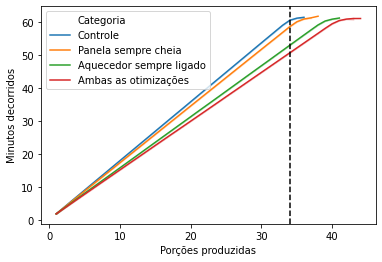

In [15]:
figura, resultados = executa_processo(tempos.to_numpy(), limite_de_tempo, numero_de_execucoes)